# Load Data

## Load Peeringdb

In [1]:
import json
from pathlib import Path
import pandas as pd

filepath = Path('../../preprocessing/data/peeringdb/peeringdb_2_dump_2025_10_21.json')

with filepath.open('r', encoding='utf-8') as f:
    dump = json.load(f)

# extract the net.data section and load into a DataFrame
net_data = dump.get('net', {}).get('data')
if net_data is None:
    raise KeyError("JSON does not contain 'net' -> 'data' structure")

net_df = pd.DataFrame(net_data)
net_df['asn'] = net_df['asn'].astype(int)
net_df = net_df[net_df['info_type'] != '']

# show a quick preview
net_df.head()

,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,policy_ratio,policy_contracts,allow_ixp_update,status_dashboard,rir_status,rir_status_updated,logo,created,updated,status
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,True,Required,False,None,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-07-27T05:33:22Z,ok
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,False,Not Required,False,https://www.akamaistatus.com/,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-10-20T12:16:12Z,ok
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,False,Not Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-01-09T13:42:07Z,ok
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,True,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-08-12T06:33:30Z,ok
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,False,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-11-28T22:55:17Z,ok


In [2]:
bgp_df = pd.read_csv('../../scripts/as_metrics_with_rpki.csv')

In [3]:
net_df = net_df.merge(bgp_df, how='inner', left_on='asn', right_on='asn')

## Load data from Clickhouse

In [4]:
ch_df = pd.read_csv('/home/jhart/asn-classifier/preprocessing/data/clickhouse/asn_geolocation_stats.csv')

## Join the dataframes

In [5]:
joined = net_df.merge(ch_df, on='asn', how='left')
joined.fillna(0, inplace=True)
joined.head()


,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,p90_km,p95_km,p99_km,min_km,max_km,pct_ips_le_100km,pct_ips_le_500km,pct_ips_le_1000km,country_entropy_bits,country_entropy_norm
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.0000
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,3440.84,3440.84,6319.63,9.45,18126.77,0.13,46.99,78.79,0.347804,0.0510
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,5511.55,5511.55,5511.55,2073.76,5511.55,0.00,0.00,0.00,0.876716,0.8767
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,124.59,161.25,167.13,3.90,6641.84,72.07,100.00,100.00,0.006834,0.0029
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,1960.31,2242.55,2401.69,19.55,14417.21,0.72,13.60,51.42,0.000063,0.0000


In [ ]:

joined["info_type"].value_counts()

info_type
Access                10973
Transit                3658
Enterprise             2146
Content                2130
Education/Research     1266
Network Services        811
Name: count, dtype: int64

# Get Stats as Plots

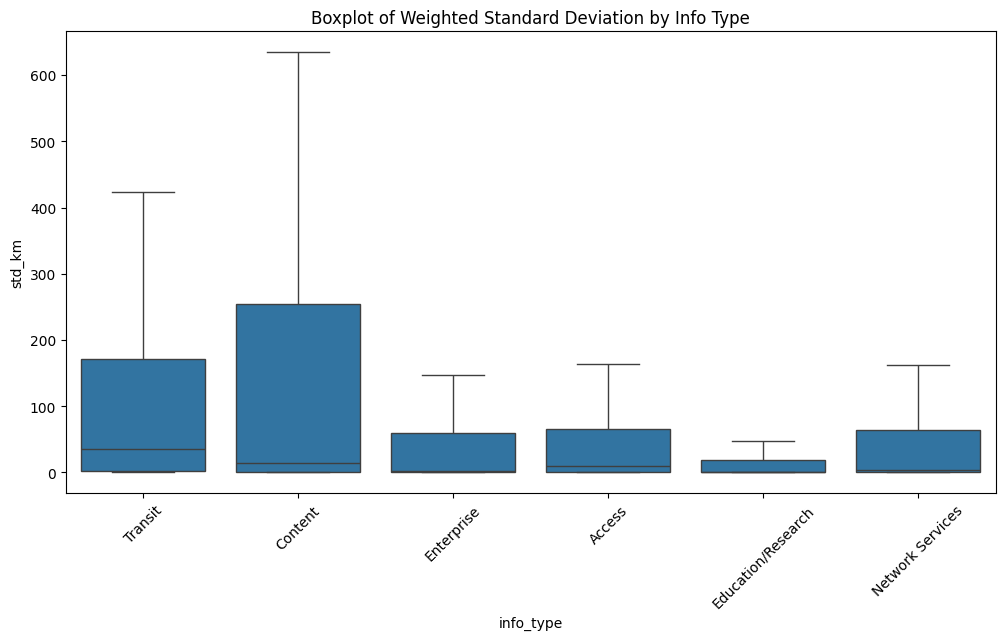

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where std_m_weighted is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['std_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='std_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Standard Deviation by Info Type')
plt.show()

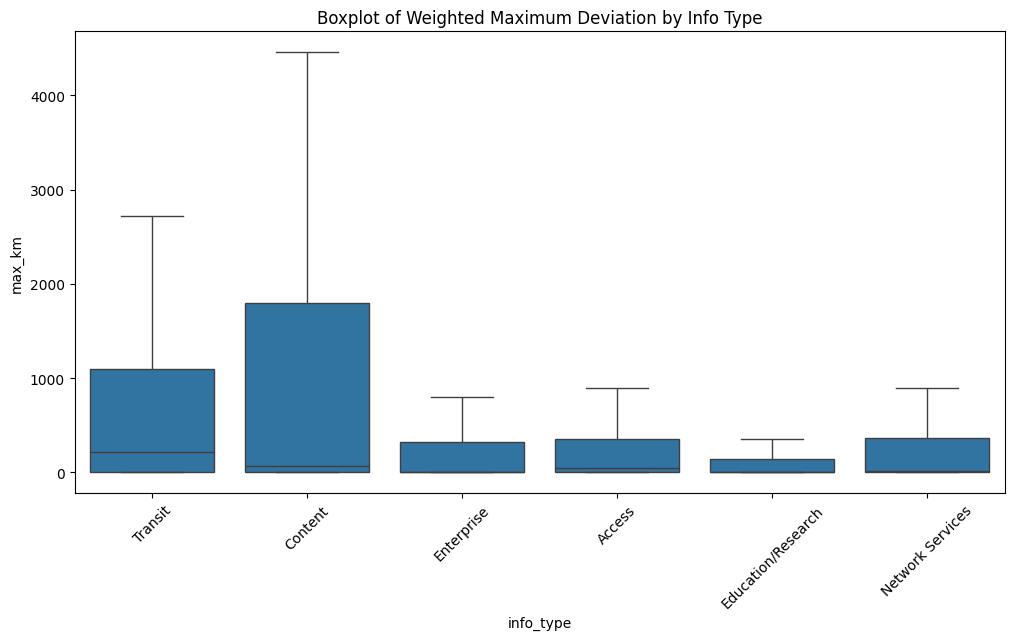

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where max_m is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['max_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='max_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Maximum Deviation by Info Type')
plt.show()

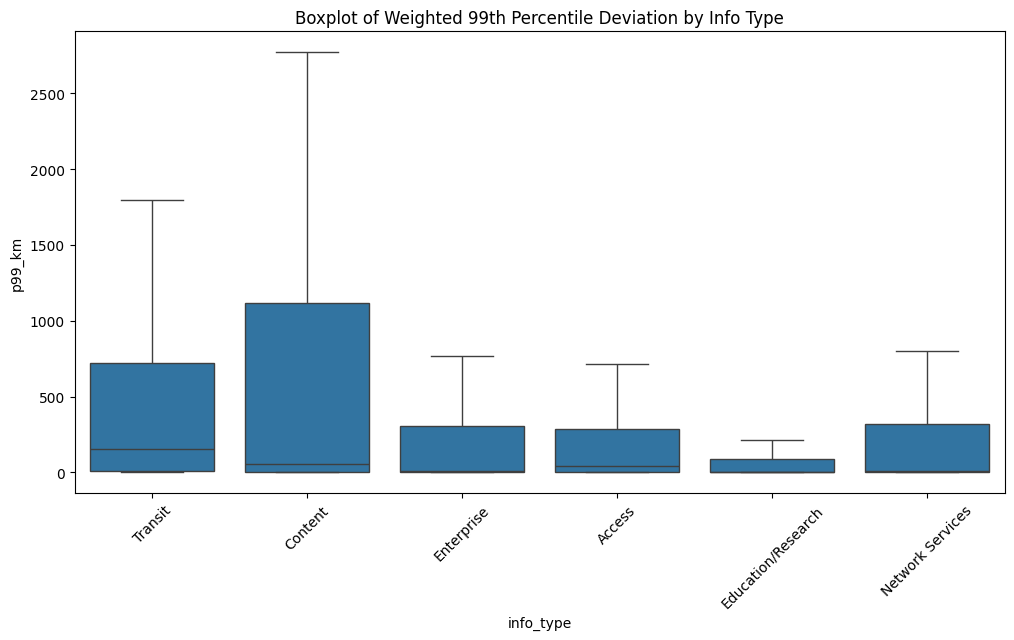

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where max_m is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['p99_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='p99_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted 99th Percentile Deviation by Info Type')
plt.show()

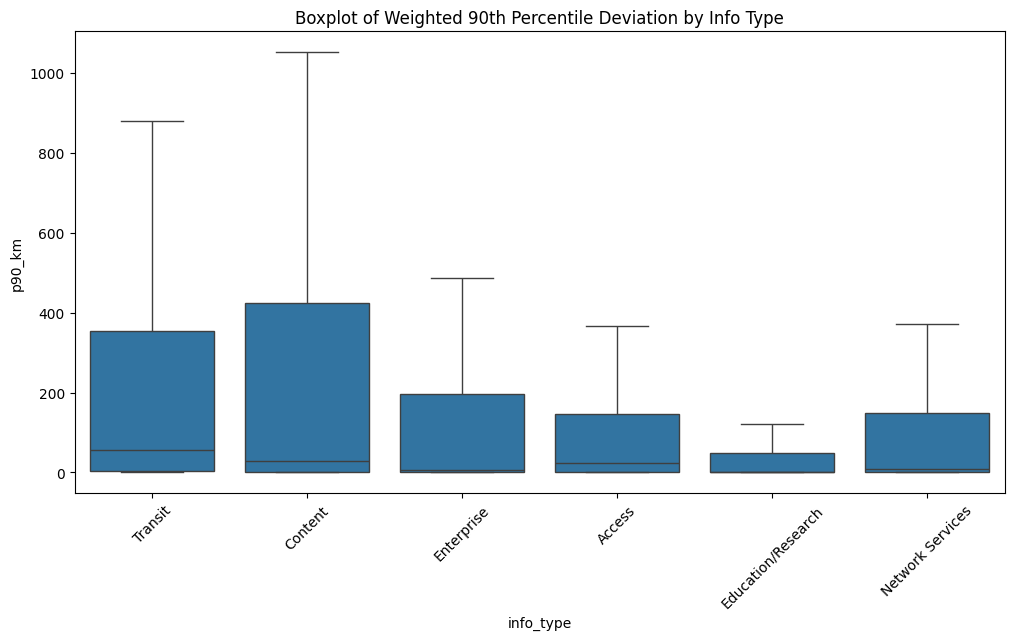

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where max_m is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['p90_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='p90_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted 90th Percentile Deviation by Info Type')
plt.show()

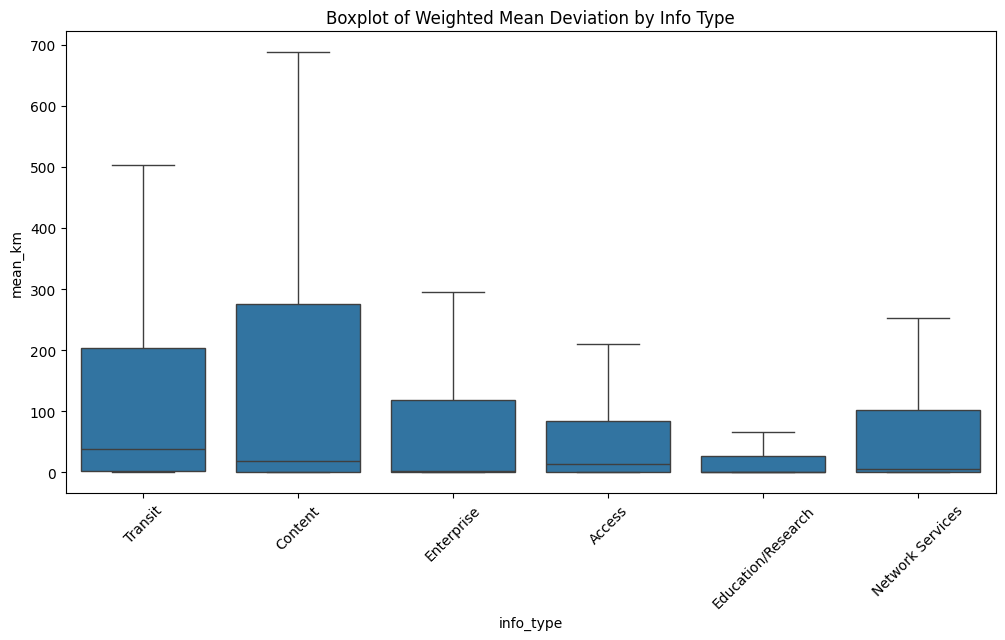

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where max_m is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['mean_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='mean_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Mean Deviation by Info Type')
plt.show()

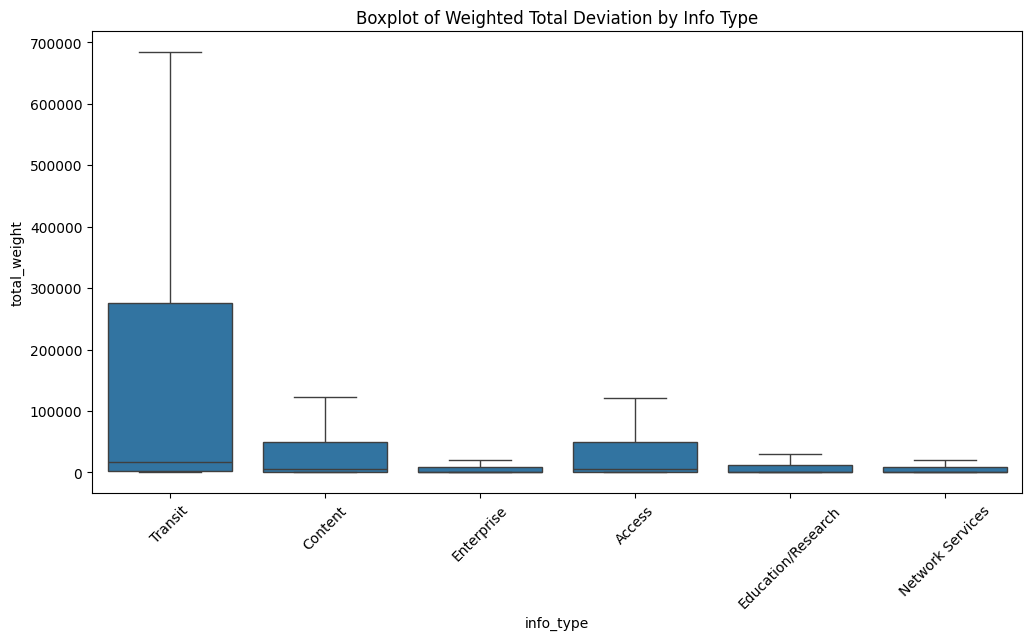

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['total_weight'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='total_weight', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Total Deviation by Info Type')
plt.show()

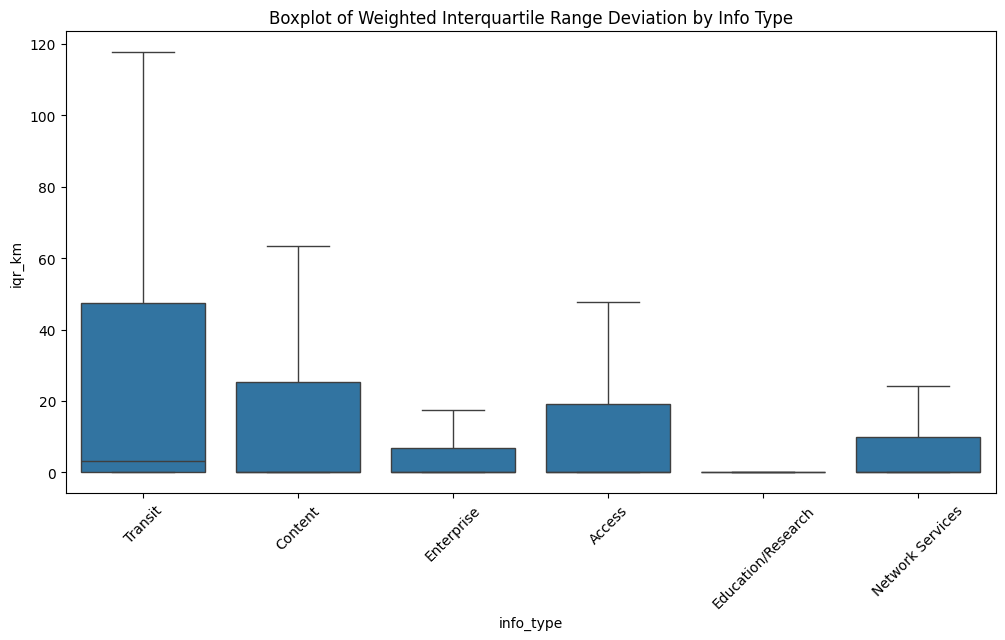

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['iqr_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='iqr_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Interquartile Range Deviation by Info Type')
plt.show()

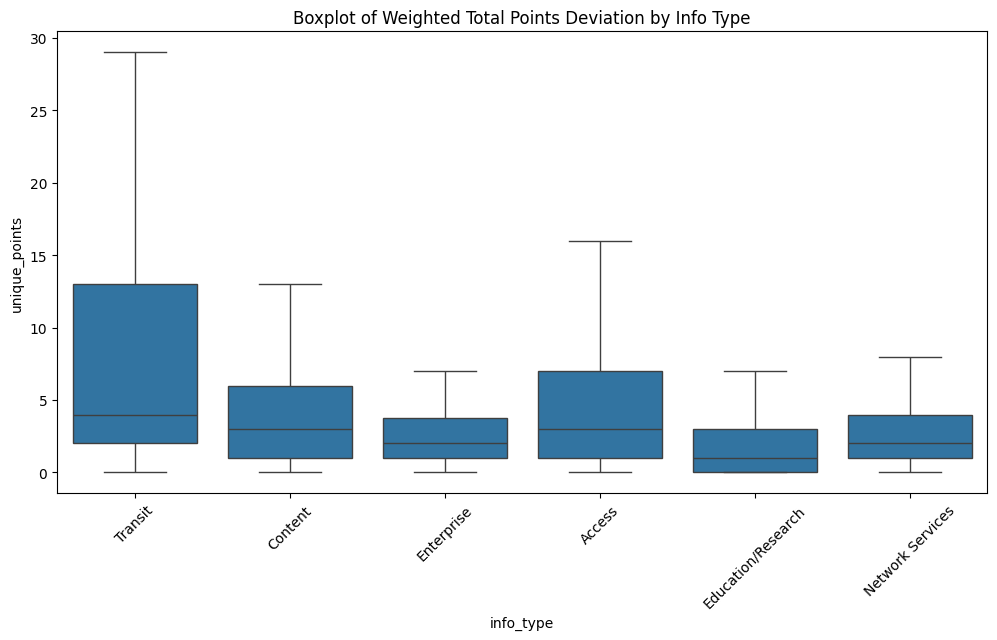

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['unique_points'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='unique_points', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Total Points Deviation by Info Type')
plt.show()

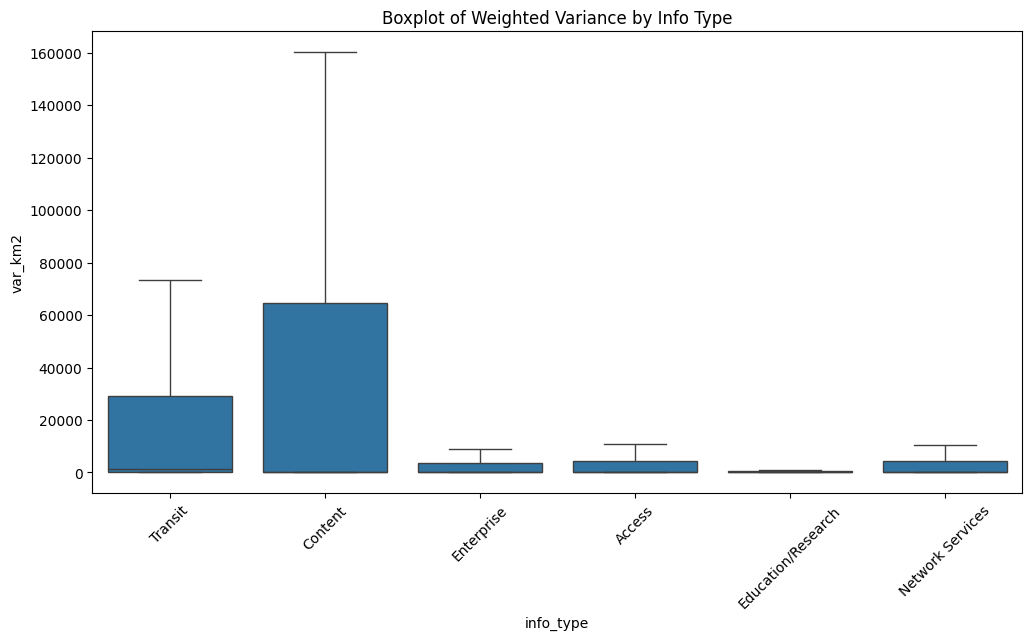

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['var_km2'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='var_km2', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Variance by Info Type')
plt.show()

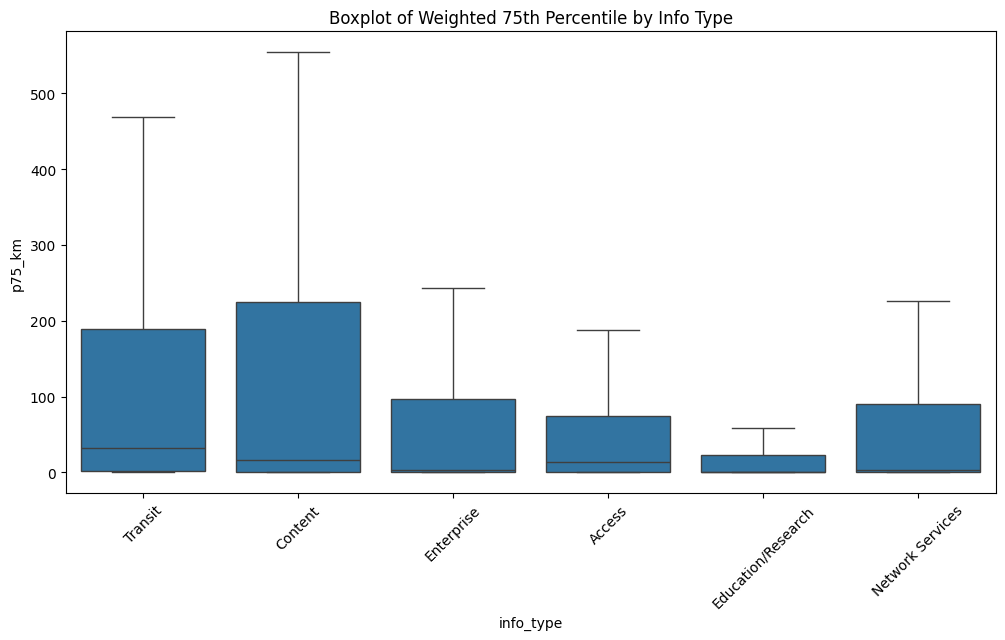

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['p75_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='p75_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted 75th Percentile by Info Type')
plt.show()

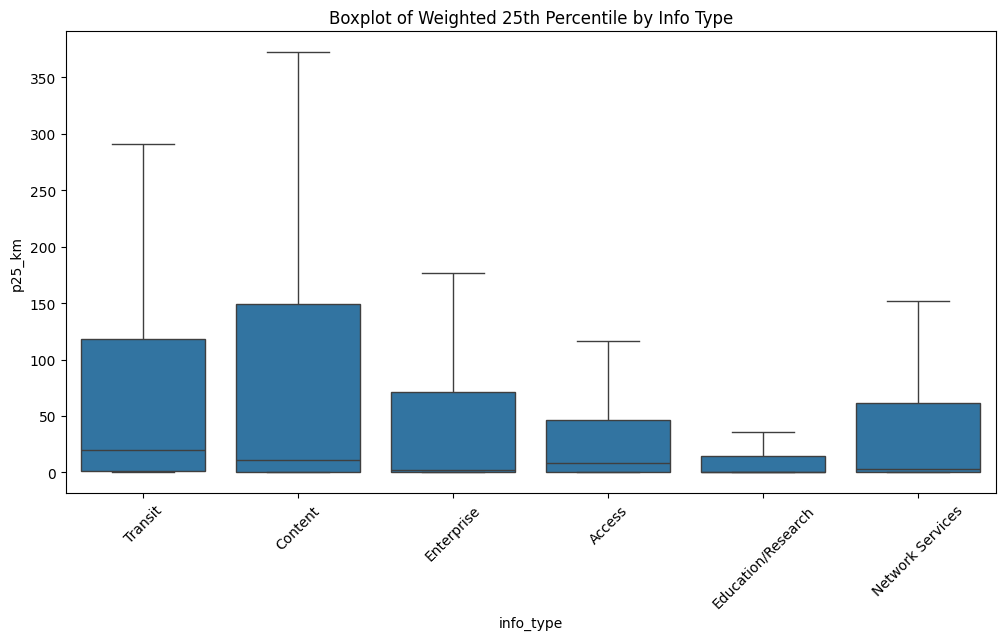

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['p25_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='p25_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted 25th Percentile by Info Type')
plt.show()

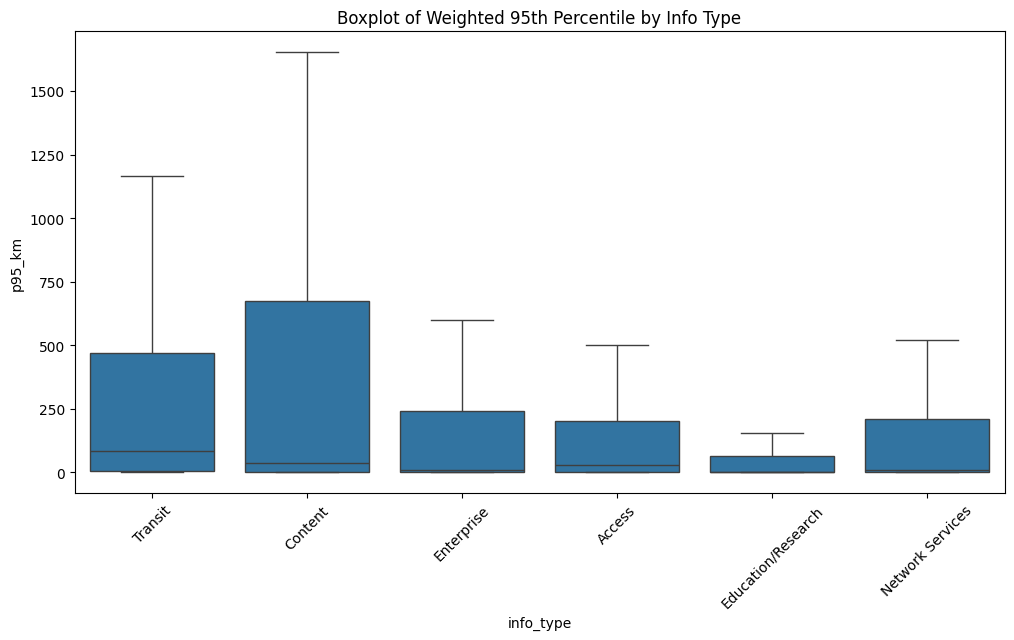

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['p95_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='p95_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted 95th Percentile by Info Type')
plt.show()

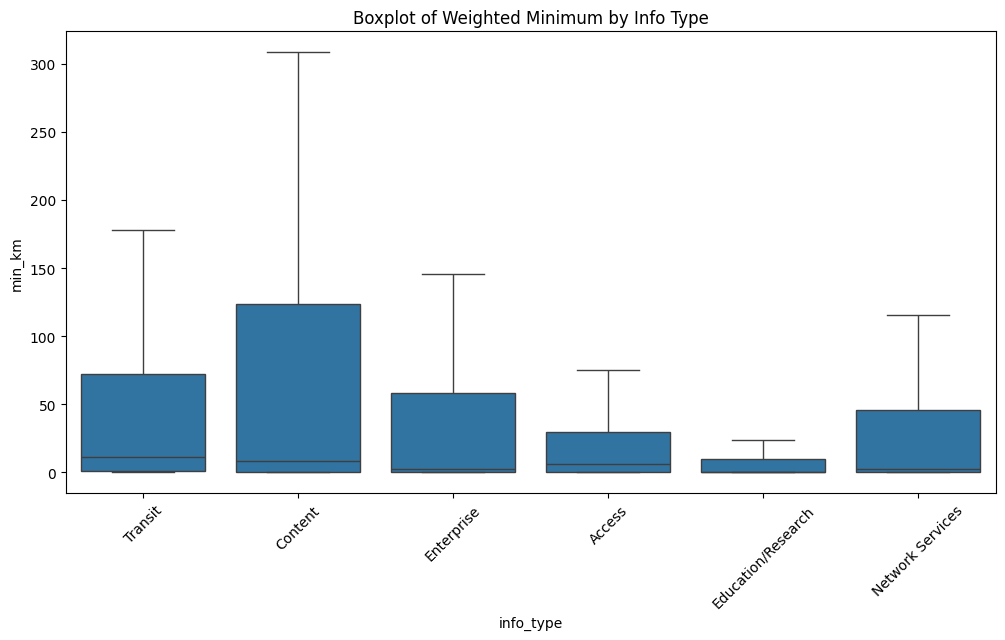

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['min_km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='min_km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Minimum by Info Type')
plt.show()

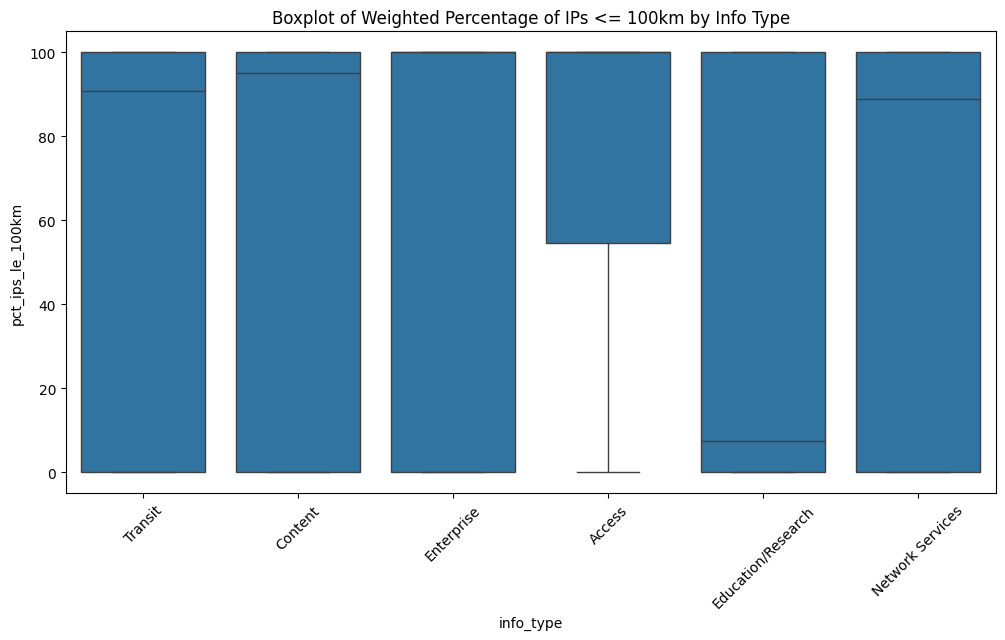

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['pct_ips_le_100km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='pct_ips_le_100km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Percentage of IPs <= 100km by Info Type')
plt.show()

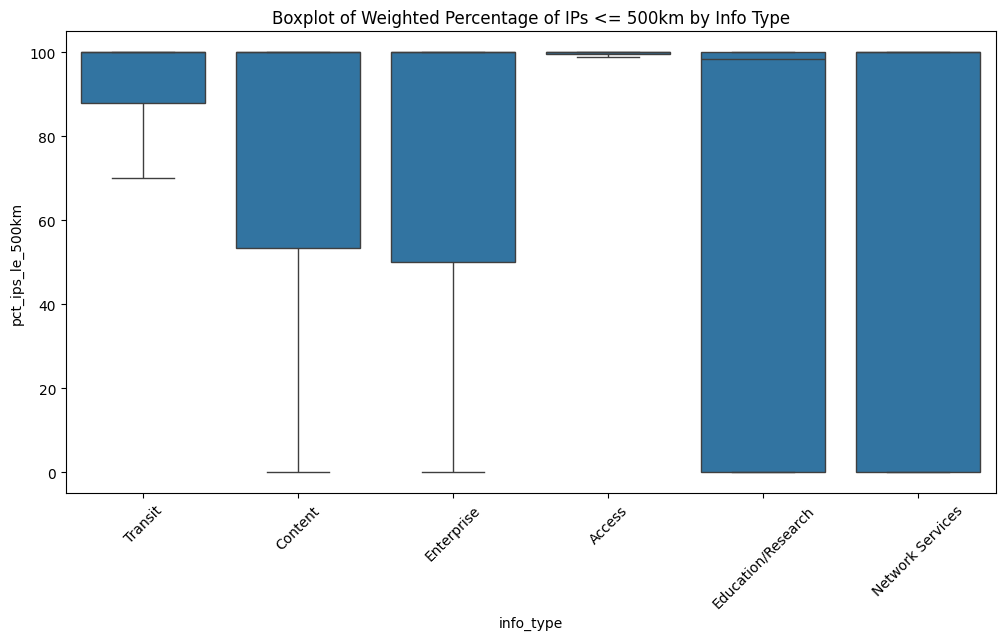

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['pct_ips_le_500km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='pct_ips_le_500km', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Percentage of IPs <= 500km by Info Type')
plt.show()

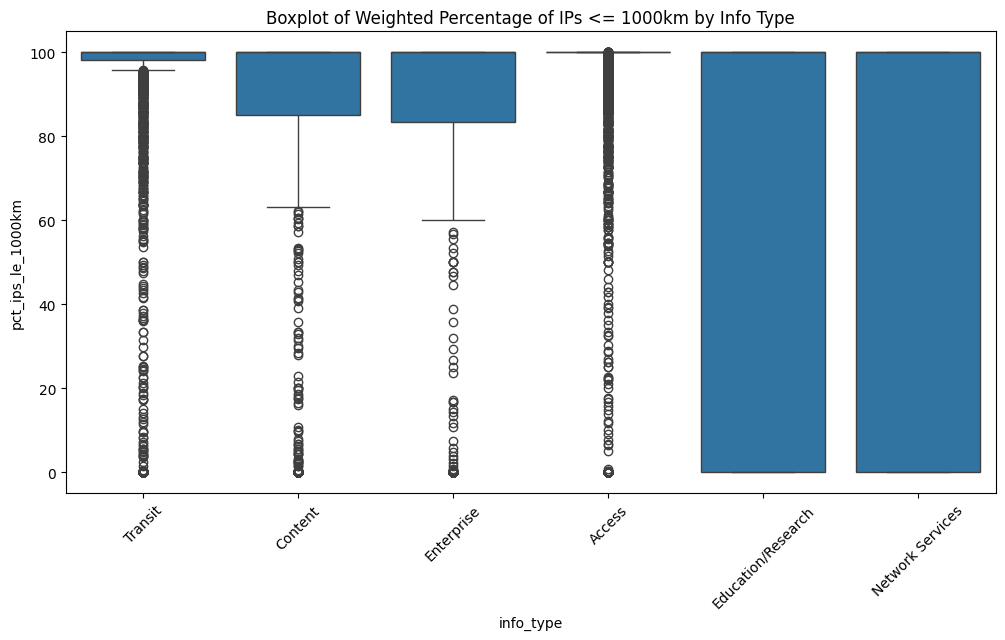

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where total_weight is NaN for cleaner plot
filtered_joined = joined.dropna(subset=['pct_ips_le_1000km'])

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_joined, x='info_type', y='pct_ips_le_1000km', showfliers=True)
plt.xticks(rotation=45)
plt.title('Boxplot of Weighted Percentage of IPs <= 1000km by Info Type')
plt.show()